# Project Overview:

**Goal:** Build an encoder-decoder LSTM model to predict stock prices 30 days ahead using historical data.
**Required Libraries:**

    - Pandas , NumPy, Matplotlib, Seaborn
    - TensorFlow, Keras, Scikit-Learn
    - yFinance, ta-lib

**Dataset Choice: Yahoo Finance API via yfinance**
Why this dataset?

    - Free & accessible
    - Real-world stock data with actual issues (missing values, weekends/holdiays gaps, stock splits)
    - Forces you to handle non-stationarity, noise, and data irregularities
    - Contains OHLCV data needed for technical indicators

First, we're going to collect data. We're going to download 10 years worth of data for multiple stocks, generally the ones in FAANG (AAPL, MSFT, GOOGL, AMZN, TSLA), however for training we're going to focus on one stock initially

In [14]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
end_date = datetime.now()
start_date = end_date - timedelta(days=365*10)

data = {}
for ticker in tickers:
    df = yf.download(ticker, start=start_date, end= end_date, interval='1d')
    data[ticker] = df
    df.to_csv(f'data/raw_{ticker}.csv')


/var/folders/11/hr72w2z52lg8rt9z9977f9vh0000gn/T/ipykernel_15304/1141164668.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end= end_date, interval='1d')
[*********************100%***********************]  1 of 1 completed
/var/folders/11/hr72w2z52lg8rt9z9977f9vh0000gn/T/ipykernel_15304/1141164668.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end= end_date, interval='1d')
[*********************100%***********************]  1 of 1 completed
/var/folders/11/hr72w2z52lg8rt9z9977f9vh0000gn/T/ipykernel_15304/1141164668.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end= end_date, interval='1d')
[*********************100%***********************]  1 of 1 completed
/var/folders/11/hr72w2z52lg8rt9z9977f9vh0000gn/T/ipykernel_15304/1141164668.py:11: Fu

We're going to initially focus on the APPL stock

In [15]:
apple_data = data['AAPL']
apple_data.to_csv('data/raw_AAPL.csv')

Now, we move on to data cleaning and exploration

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Initial inspection

In [17]:
apple_data = pd.read_csv('data/raw_AAPL.csv', skiprows=[1,2], index_col=0, parse_dates=True)
apple_data.index.name = 'Date'
# Flatten the multi-level columns if they exist
if isinstance(apple_data.columns, pd.MultiIndex):
    apple_data.columns = apple_data.columns.get_level_values(0)

print("First 5 rows of the dataset:")
print(apple_data.head())
print("---------------------")
print("Data Info:")
print(apple_data.info())
print("---------------------")
print("Statistical Summary:")
print(apple_data.describe())
print("---------------------")
print(f"\nMissing Values:\n{apple_data.isnull().sum()}")
print("---------------------")
print(f"\nData shape: {apple_data.shape}")
print("---------------------")
print(f"\nDate range:\nFrom {apple_data.index.min()} to {apple_data.index.max()}")

First 5 rows of the dataset:
                Close       High        Low       Open     Volume
Date                                                             
2015-11-30  26.672977  26.923248  26.548969  26.603081  156721200
2015-12-01  26.456520  26.787960  26.348296  26.774432  139409600
2015-12-02  26.217522  26.630130  26.172429  26.456518  133546400
2015-12-03  25.974018  26.332515  25.753060  26.278403  166278000
2015-12-04  26.837574  26.887177  25.953736  25.994320  231108000
---------------------
Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2514 entries, 2015-11-30 to 2025-11-26
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2514 non-null   float64
 1   High    2514 non-null   float64
 2   Low     2514 non-null   float64
 3   Open    2514 non-null   float64
 4   Volume  2514 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 117.8 KB
None
---------------------
Statistical Su

Checking for missing values to carry on Data cleaning and exploration

In [18]:
print(apple_data.isnull().sum())
apple_data.head()

Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


,Close,High,Low,Open,Volume
Date,,,,,
2015-11-30,26.672977,26.923248,26.548969,26.603081,156721200
2015-12-01,26.456520,26.787960,26.348296,26.774432,139409600
2015-12-02,26.217522,26.630130,26.172429,26.456518,133546400
2015-12-03,25.974018,26.332515,25.753060,26.278403,166278000
2015-12-04,26.837574,26.887177,25.953736,25.994320,231108000


let's check for outliers now, generally outliers can distort model training, but in stocks, some of these are real events (earnings, splits), therefore we're going to check for extreme outliers in Volume, flag them and do some visualizations

Volume outliers found: 31


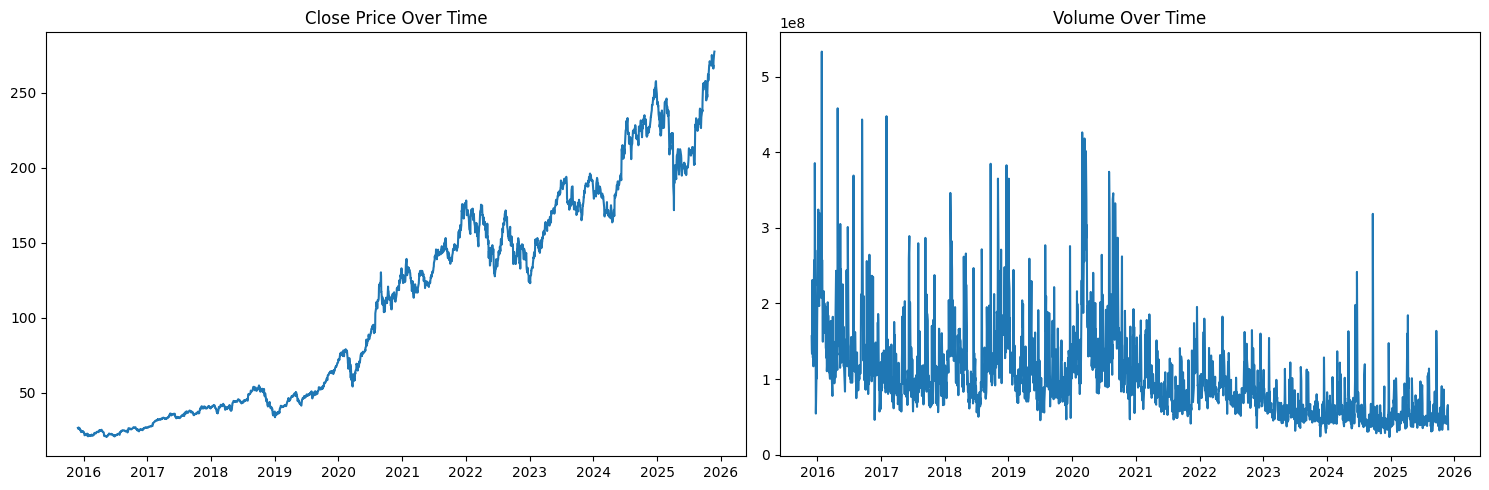

In [19]:
Q1 = apple_data['Volume'].quantile(0.25)
Q3 = apple_data['Volume'].quantile(0.75)
IQR = Q3 - Q1

# flagging outliers, stock splits can cause legitimate spikes in volume
volume_outliers = apple_data[(apple_data['Volume'] < (Q1 - 3 * IQR)) | (apple_data['Volume'] > (Q3 + 3 * IQR))]
print(f"Volume outliers found: {len(volume_outliers)}")

# visualizing to determine if removals are needed
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(apple_data['Close'])
plt.title('Close Price Over Time')
plt.subplot(1,2,2)
plt.plot(apple_data['Volume'])
plt.title('Volume Over Time')
plt.tight_layout()
plt.savefig('plots/01_raw_data_visualiszation.png')
plt.show()

now, let's check for duplicate dates

In [20]:
duplicates = apple_data.index.duplicated().sum()
print(f"Duplicate dates: {duplicates}")

Duplicate dates: 0


Let's now understand volatility, trends, and distribution to help us interpret model predictions.

In [21]:
apple_data['Returns'] = apple_data['Close'].pct_change()
apple_data['Daily_Range'] = apple_data['High'] - apple_data['Low']

print(f"Average daily return: {apple_data['Returns'].mean()*100:.2f}%")
print(f"Return volatility: {apple_data['Returns'].std()*100:.2f}%")
print(f"Average daily range: {apple_data['Daily_Range'].mean():.2f}")


Average daily return: 0.11%
Return volatility: 1.83%
Average daily range: 2.35


Let's do some visualizations for better understanding

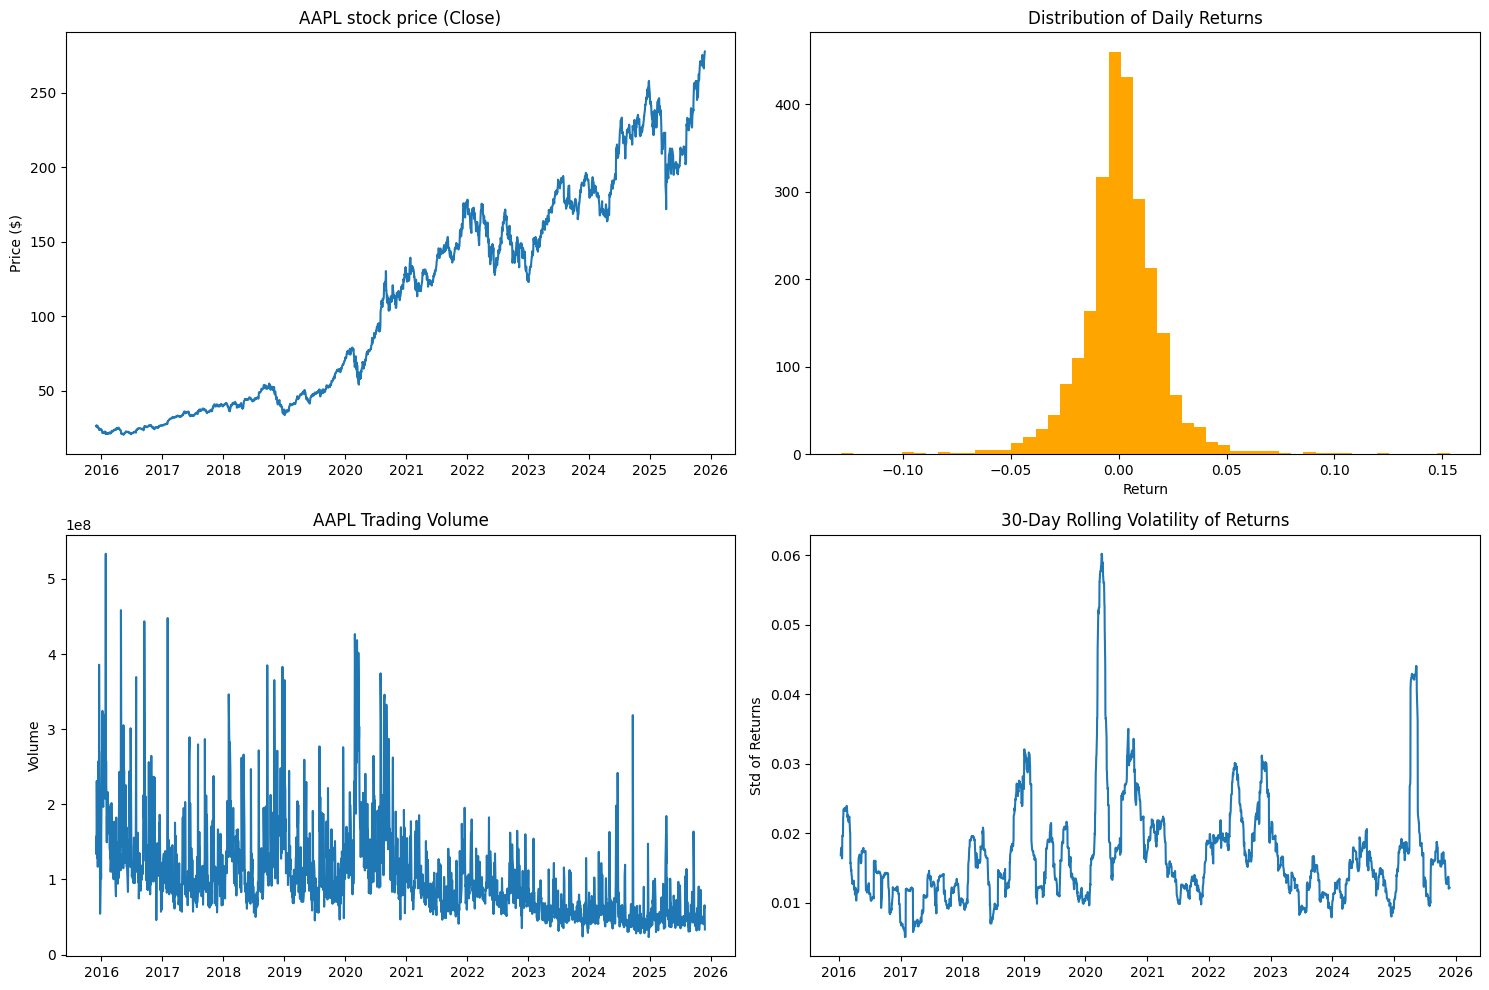

In [22]:
fig, axes = plt.subplots(2,2, figsize=(15,10))
# Price trend
axes[0,0].plot(apple_data['Close'])
axes[0,0].set_title('AAPL stock price (Close)')
axes[0,0].set_ylabel('Price ($)')

# Returns distribution
axes[0,1].hist(apple_data['Returns'].dropna(), bins=50, color='orange')
axes[0,1].set_title('Distribution of Daily Returns')
axes[0,1].set_xlabel('Return')

#Volume
axes[1,0].plot(apple_data['Volume'])
axes[1,0].set_title('AAPL Trading Volume')
axes[1,0].set_ylabel('Volume')

#Price volatility
rolling_std = apple_data['Returns'].rolling(window=30).std()
axes[1,1].plot(rolling_std)
axes[1,1].set_title('30-Day Rolling Volatility of Returns')
axes[1,1].set_ylabel('Std of Returns')

plt.tight_layout()
plt.savefig('plots/02_EDA.png')
plt.show()

To prevent extreme values from dominating (Trading Volume), we're going to cap the trading volume

In [23]:
volume_99th = apple_data['Volume'].quantile(0.99)
apple_data['Volume'] = apple_data['Volume'].clip(upper=volume_99th)

Now, let's move on to feature engineering

Why each indicator:

    - SMA/EMA: Identifying trend direction and support resistance levels
    - MACD: Captures momentum changes and trend reversals
    - RSI: Identify overbought (>70) and oversold (<30) conditions
    - Bollinger Bands: Measures volatility; prices outside bands signal potential reversals
    - ATR: Quantifies market volatility for risk assessment

In [24]:
import ta # technical analysis library
apple_dataFE = apple_data.copy()

# simple moving averages - trend indicators
apple_dataFE['SMA_10'] = apple_dataFE['Close'].rolling(window=10).mean()
apple_dataFE['SMA_50'] = apple_dataFE['Close'].rolling(window=50).mean()
apple_dataFE['SMA_20'] = apple_dataFE['Close'].rolling(window=20).mean()

# Exponential moving averages
apple_dataFE['EMA_12'] = apple_dataFE['Close'].ewm(span=12, adjust=False).mean()
apple_dataFE['EMA_26'] = apple_dataFE['Close'].ewm(span=26, adjust=False).mean()

# MACD
apple_dataFE['MACD'] = apple_dataFE['EMA_12'] - apple_dataFE['EMA_26']
apple_dataFE['MACD_Signal'] = apple_dataFE['MACD'].ewm(span=9, adjust=False).mean()
apple_dataFE['MACD_Hist'] = apple_dataFE['MACD'] - apple_dataFE['MACD_Signal']

# RSI - relative strenght index
delta = apple_dataFE['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
apple_dataFE['RSI'] = 100 - (100 / (1 + rs))

# Bollinger Bands for volatility
apple_dataFE['BB_Middle'] = apple_dataFE['Close'].rolling(window=20).mean()
bb_std = apple_dataFE['Close'].rolling(window=20).std()
apple_dataFE['BB_Upper'] = apple_dataFE['BB_Middle'] + (2 * bb_std)
apple_dataFE['BB_Lower'] = apple_dataFE['BB_Middle'] - (2 * bb_std)
apple_dataFE['BB_Width'] = apple_dataFE['BB_Upper'] - apple_dataFE['BB_Lower']

# ATR - Average True Range, volatilitymeasure
hig_low = apple_dataFE['High'] - apple_dataFE['Low']
hig_close = np.abs(apple_dataFE['High'] - apple_dataFE['Close'].shift())
low_close = np.abs(apple_dataFE['Low'] - apple_dataFE['Close'].shift())
true_range = pd.concat([hig_low, hig_close, low_close], axis=1).max(axis=1)
apple_dataFE['ATR'] = true_range.rolling(window=14).mean()

print(f"Features created:{apple_dataFE.shape[1]} columns")

Features created:21 columns


Now we're going to create Lag Features, given LSTM learns from sequences, and explicit lag features can boost performance

Lag features is when we explicitly incorporate past values to provide context.

**How Lag Features Improve Model Predictions:**

Tree based models like XGBoost split data into decision nodes based on observed relationships. By adding lag features:

    - The model learns that recent values are predictive
    - If there is a weekly trend, the model recognizes that the value from 7 days ago is an important predictor
    - If a time series exhibits monthly sensionality, the 30-day lag provides critical context.

So basically, without any lag features, a ML model is essentially trying to predict the next frame of a movie for exeample by looking at a single snapshot, rather than understanding the sequence and context.

In [ ]:
for lag in [1,2,3,5,7,14,21,30]:
    apple_dataFE[f'Close_lag_{lag}'] = apple_dataFE['Close'].shift(lag)

for lag in [1,7,14]:
    apple_dataFE[f'Volume_lag_{lag}'] = apple_dataFE['Volume'].shift(lag)
    


In [29]:
apple_dataFE.to_csv('data/feature_engineered_AAPL_TEST.csv')

More lags for the Close price lags because price, evidently, has strong temporal dependecies and we're predicting price here, for the volume though, we chose to work ith fewer lags because volume is less predictive and more lags = diminishing returns.

Now we're going to create **Rolling Window Features**.
They capture short-term trends and volatility patterns.
So, **How do Rolling Window Features Improve Model Predictions?**

    - Moving averages help the model recognize if values are increasing or decreasing over time.
    - Rolling standard deviation informs the model about the stability of past values, if recent values have been volatile, predictions should be more cautious.

In [26]:
windows = [7,14,30]
for window in windows:
    apple_dataFE[f"Close_Rolling_Mean_{window}"] = apple_dataFE['Close'].rolling(window=window).mean()
    apple_dataFE[f"Close_Rolling_Std_{window}"] = apple_dataFE['Close'].rolling(window=window).std()
    apple_dataFE[f"Close_Rolling_Min_{window}"] = apple_dataFE['Close'].rolling(window=window).min()
    apple_dataFE[f"Close_Rolling_Max_{window}"] = apple_dataFE['Close'].rolling(window=window).max()
    
apple_dataFE["Momentum_7"] = apple_dataFE['Close'] - apple_dataFE['Close_Rolling_Mean_7']
apple_dataFE['Momentum_14'] = apple_dataFE['Close'] - apple_dataFE['Close_Rolling_Mean_14']
apple_dataFE['Momentum_30'] = apple_dataFE['Close'] - apple_dataFE['Close_Rolling_Mean_30']

print(f"After rolling features: {apple_dataFE.shape[1]} columns")

After rolling features: 47 columns


Now, to not keep things cluttered, we're going to need to clean up and prepare the final feature set

In [30]:
apple_dataFE = apple_dataFE.dropna()

feature_columns = ['Close', 'Volume','High',
                   'Low','SMA_10','SMA_20','SMA_50',
                   'EMA_12','EMA_26','MACD','MACD_Signal',
                   'RSI','BB_Upper','BB_Lower','BB_Width',
                   'ATR', 'Close_lag_1', 'Close_lag_7', 'Close_lag_30',
                   'Close_Rolling_Mean_7', 'Close_Rolling_Std_7',
                   'Close_Rolling_Mean_14', 'Close_Rolling_Std_14',
                   'Close_Rolling_Mean_30', 'Close_Rolling_Std_30',
                   'Momentum_7',
                   'Momentum_30']

apple_final = apple_dataFE[feature_columns].copy()
print(f"Final feature set shape: {apple_final.shape}")
print(f"Features:\n{apple_final.columns.tolist()}")
apple_final.to_csv('data/featured_AAPL.csv')
print(apple_final.head())

Final feature set shape: (2465, 27)
Features:
['Close', 'Volume', 'High', 'Low', 'SMA_10', 'SMA_20', 'SMA_50', 'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'RSI', 'BB_Upper', 'BB_Lower', 'BB_Width', 'ATR', 'Close_lag_1', 'Close_lag_7', 'Close_lag_30', 'Close_Rolling_Mean_7', 'Close_Rolling_Std_7', 'Close_Rolling_Mean_14', 'Close_Rolling_Std_14', 'Close_Rolling_Mean_30', 'Close_Rolling_Std_30', 'Momentum_7', 'Momentum_30']
                Close       Volume       High        Low     SMA_10  \
Date                                                                  
2016-02-10  21.370293  169374400.0  21.841813  21.331755  21.558367   
2016-02-11  21.241079  200298800.0  21.472307  20.989451  21.561038   
2016-02-12  21.306818  161405600.0  21.422432  21.084660  21.497006   
2016-02-16  21.907555  196231600.0  21.955160  21.447369  21.513564   
2016-02-17  22.243057  179452800.0  22.263459  21.796473  21.607640   

               SMA_20     SMA_50     EMA_12     EMA_26      MACD  ...  \
Date 

Onto the next phase: Data Preprocessing for LSTM

First we're going to start with train-validation-test split, and for that we're going to use chronological split for time series, never a random split. (very critical)